In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import matplotlib.dates as mdates

In [2]:

def fetch_data(ticker, start_date, end_date):
    print(f"Downloading data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)

    # Handle potential MultiIndex columns in newer yfinance versions
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1) if ticker in data.columns.levels[1] else data

    # Keep 'Adj Close' if available, else 'Close'
    price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    data = data[[price_col]].copy()
    data.rename(columns={price_col: 'Price'}, inplace=True)

    # Calculate Log Returns (better for modeling than simple % change)
    # r_t = ln(P_t / P_{t-1})
    data['Returns'] = np.log(data['Price'] / data['Price'].shift(1))
    data.dropna(inplace=True)

    return data


In [3]:
def fit_hmm(returns, n_components=3):
    print(f"Fitting Gaussian HMM with {n_components} states...")

    # Reshape data for hmmlearn (must be 2D array)
    X = returns.values.reshape(-1, 1)

    # Initialize HMM
    # covariance_type='diag' or 'full'. For 1D data, they are equivalent.
    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(X)

    # Predict the hidden states
    hidden_states = model.predict(X)

    return model, hidden_states

In [4]:

def analyze_regimes(model, n_components):
    print("\n--- Regime Analysis ---")
    for i in range(n_components):
        print(f"Hidden State {i}")
        print(f"  Mean Return: {model.means_[i][0]:.6f}")
        print(f"  Variance: {np.diag(model.covars_[i])[0]:.6f}")
        print("-" * 20)

    # Transition Matrix
    print("\nTransition Matrix (Probability of switching states):")
    print(model.transmat_)

def plot_market_regimes(data, hidden_states, ticker):
    # Create a copy to map states
    plot_data = data.copy()
    plot_data['State'] = hidden_states

    # Plot 1: Returns colored by State
    plt.figure(figsize=(14, 6))
    colors = ['green', 'red', 'blue', 'orange'] # Add more if n_components > 4

    for i in range(model.n_components):
        state_data = plot_data[plot_data['State'] == i]
        plt.scatter(state_data.index, state_data['Returns'],
                    label=f'State {i}', c=colors[i], s=10, alpha=0.6)

    plt.title(f'{ticker} Daily Returns by Market Regime (HMM)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylabel('Log Returns')
    plt.show()

    # Plot 2: Stock Price colored by State
    # This requires creating line segments for contiguous states
    plt.figure(figsize=(14, 6))

    # We plot the whole line first in grey
    plt.plot(plot_data.index, plot_data['Price'], c='grey', alpha=0.3, label='Price')

    # Overlay colored dots/segments
    for i in range(model.n_components):
        mask = (hidden_states == i)
        plt.scatter(plot_data.index[mask], plot_data['Price'][mask],
                    c=colors[i], s=5, label=f'State {i}', zorder=10)

    plt.title(f'{ticker} Stock Price with Hidden Regimes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylabel('Price ($)')
    plt.show()


/tmp/ipython-input-2842167488.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fitting Gaussian HMM with 3 states...



--- Regime Analysis ---
Hidden State 0
  Mean Return: 0.000625
  Variance: 0.000069
--------------------
Hidden State 1
  Mean Return: 0.001261
  Variance: 0.000051
--------------------
Hidden State 2
  Mean Return: -0.001762
  Variance: 0.000459
--------------------

Transition Matrix (Probability of switching states):
[[9.70791683e-04 9.98901382e-01 1.27826569e-04]
 [9.20764349e-01 5.96439153e-02 1.95917359e-02]
 [4.33240321e-02 1.50646640e-03 9.55169501e-01]]

Interpretation Hint:
Look at the Variance printed above.
The State with the HIGHEST Variance is likely the 'High Volatility/Crash' regime.
The State with the POSITIVE Mean and LOW Variance is likely the 'Bull/Stable' regime.


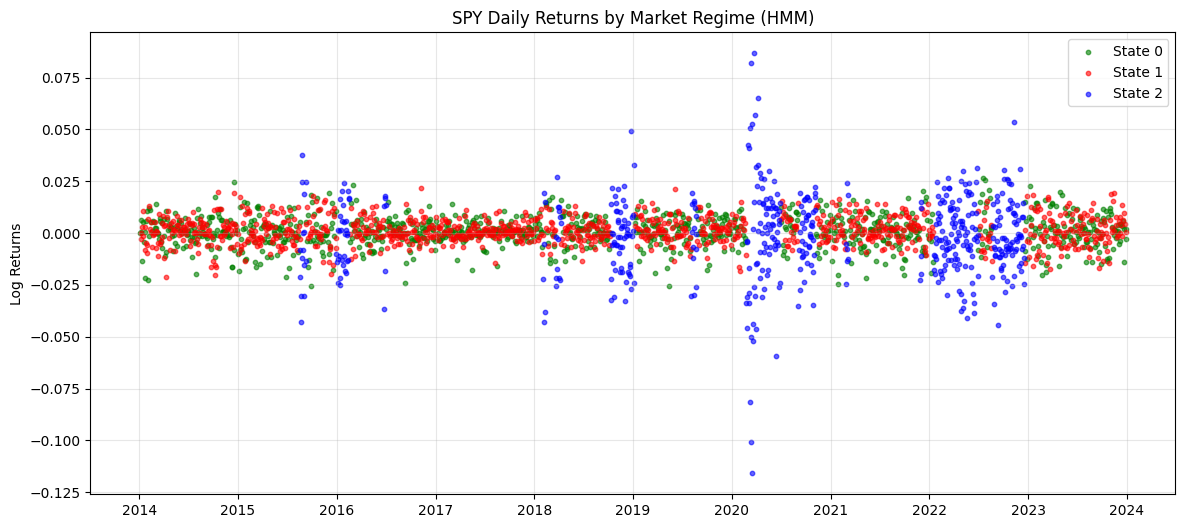

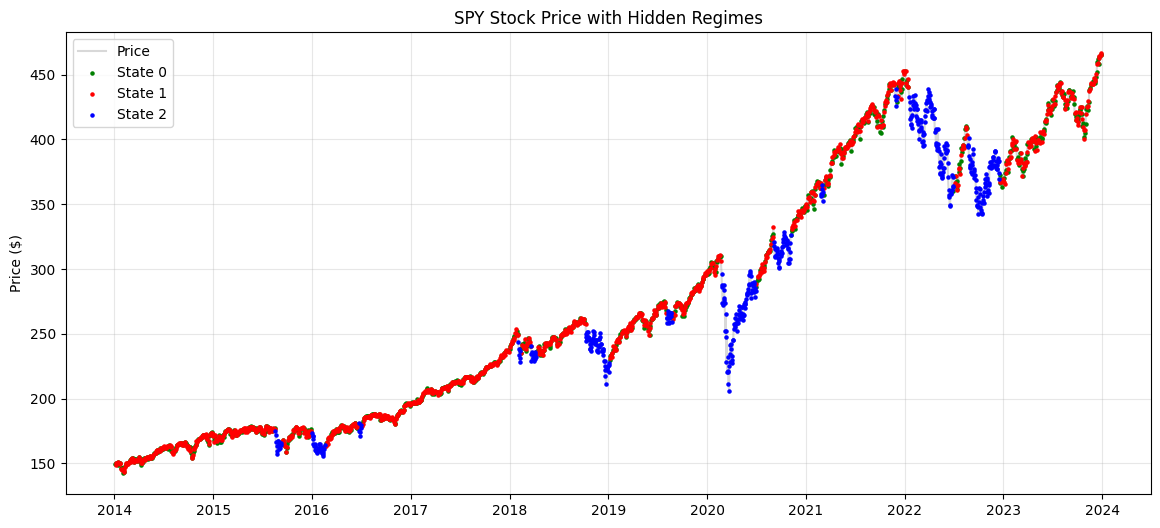

In [7]:

if __name__ == "__main__":
    # Settings
    TICKER = "SPY" # S&P 500 ETF
    START_DATE = "2014-01-01"
    END_DATE = "2024-01-01"
    N_STATES = 3 # Bear, Bull, Stagnant/High Volatility

    # 1. Get Data
    df = fetch_data(TICKER, START_DATE, END_DATE)

    # 2. Fit Model
    model, states = fit_hmm(df['Returns'], n_components=N_STATES)

    # 3. Analyze
    analyze_regimes(model, N_STATES)

    # Interpretation Helper
    # Usually: High Variance = High Volatility (Bear/Crash), Low Variance = Stable (Bull)
    print("\nInterpretation Hint:")
    print("Look at the Variance printed above.")
    print("The State with the HIGHEST Variance is likely the 'High Volatility/Crash' regime.")
    print("The State with the POSITIVE Mean and LOW Variance is likely the 'Bull/Stable' regime.")

    # 4. Visualize
    plot_market_regimes(df, states, TICKER)